In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.collision_operator_HG_1D import CollisionOperatorHG1D
from model.deeponet import *
import torch

In [2]:
L = 10.0  # Length of the 1D domain
n_x = 100  # Number of spatial grid points
dx = L / n_x  # Spatial grid size
sigma_t = 1.0  # Total cross-section
sigma_s = 0.5  # Scattering cross-section
source = np.zeros(n_x)  # Source term

# Angular discretization (Discrete Ordinates)
n_q = 100  # Number of discrete angles
Q = CollisionOperatorHG1D(integrator_order=n_q, anisotropy_param=0.0)
omega = Q.get_quad_pts()
w_q = Q.get_quad_weights()
# Initialize angular flux and boundary conditions
f_init = np.zeros((n_q, n_x))
f_init[:, 0] = 1.0  # Left boundary (Dirichlet boundary condition)
f_init[:, - 1] = 0.0  # Right boundary (Dirichlet boundary condition)

# Define the time step and number of time steps
dt = 0.4 * dx  # obeys cfl
n_t = 100

In [3]:
gparams = {
     'name': '3_8_3_8_wo_bias',
     'seed': 0,
     'use_squeue': False,
     'dimension': 1,
     'data_file': 'legendre',
     'integration_order': 100,
     'model': 'deeponet',
     'branch_hidden': [100, 8, 8, 8],
     'trunk_hidden': [1, 8, 8, 8],
     'act': 'tanh',
     'd_out': 1,
     'use_bias': 'no',
     'use_gram': False,
     'batch_size': 0,
     'epochs': 100000,
     'lr': 0.001,
     'lambda': 0.0
}
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '1D/entropy/3_64_3_64_wo_bias',
    '1D/entropy/3_64_3_64_w_bias',
    '1D/entropy/3_64_3_64_soft_lamb01',
    '1D/entropy/3_64_3_64_hard_gram',
    '1D/entropy/3_64_3_64_hard_special',
    '1D/toy/3_8_3_8_wo_bias',
    '1D/toy/3_8_3_8_w_bias',
    '1D/toy/3_8_3_8_soft_lamb01',
    '1D/toy/3_8_3_8_hard_gram',
    '1D/toy/3_8_3_8_hard_special'
]

## guad pts and weights
integration_order=gparams['integration_order']
if gparams['dimension']==1:
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,1).cpu()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cpu()
    size_domain=2

In [4]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+list_filename[idx_model]+'/args.bin', map_location=torch.device('cpu'))
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## We want a cpu model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cpu()
        save_model=torch.load('results/'+model+'/final.bin', map_location=torch.device('cpu'))
        DeepONet.load_state_dict(save_model['state_dict'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

In [5]:
def get_upwind_flux(i, omega_q, f_q):
    if omega_q >= 0:
        return omega_q * f_q[i - 1]
    return omega_q * f_q[i]

In [7]:
def run_simulation(f_init, n_x, n_q, n_t, dt, dx, sigma_s, sigma_t, source, omega, model, grid, w_q, normalize):
    f_kin = np.copy(f_init)
    fluxes = np.zeros(shape=(n_q, n_x))
    # Perform time-stepping
    for k in range(n_t - 1):
        for i in range(1, n_x - 1):
            for q in range(n_q):
                fluxes[q, i] = get_upwind_flux(i, omega[q], f_kin[q, :])
        for i in range(1, n_x - 1):
            if normalize == False:
                _f = torch.FloatTensor(f_kin[:, i].reshape(1, 1,-1))
                collision = model(_f, grid).squeeze().detach().numpy()
            else:
                mass = (w_q @ f_kin[:, i])
                if mass == 0:
                    _f = torch.FloatTensor(f_kin[:, i].reshape(1, 1,-1))
                    collision = model(_f, grid).squeeze().detach().numpy()
                else:
                    f_normalized = f_kin[:, i] / mass
                    _f = torch.FloatTensor(f_normalized.reshape(1, 1, -1))
                    collision = model(_f, grid).squeeze().detach().numpy() * mass
                
            for q in range(n_q):
                # Update angular flux using finite difference method
                f_kin[q, i] = f_kin[q, i] - dt / dx * (
                        fluxes[q, i + 1] - fluxes[q, i]) + dt * collision[q] + dt * source[i]

    return f_kin

In [27]:
f_tN = run_simulation(f_init, n_x, n_q, n_t, dt, dx, sigma_s, sigma_t, source, omega, models[1], grid, w_q, True)

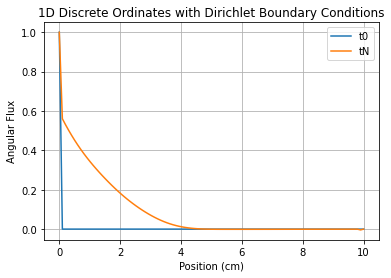

In [28]:
f_res_tn = w_q @ f_tN / 2.
f_res_t0 = w_q @ f_init / 2.
# Plot the angular flux for one angle (e.g., the first angle)
plt.plot(np.linspace(0, L, n_x), f_res_t0)
plt.plot(np.linspace(0, L, n_x), f_res_tn)
plt.xlabel('Position (cm)')
plt.ylabel('Angular Flux')
plt.title('1D Discrete Ordinates with Dirichlet Boundary Conditions')
plt.legend(['t0', 'tN'])
plt.grid(True)
#plt.savefig("wo_bias.png")

In [10]:
f_tN = run_simulation(f_init, n_x, n_q, n_t, dt, dx, sigma_s, sigma_t, source, omega, models[2], grid, w_q, True)

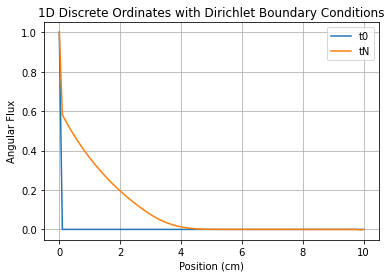

In [11]:
f_res_tn = w_q @ f_tN / 2.
f_res_t0 = w_q @ f_init / 2.
# Plot the angular flux for one angle (e.g., the first angle)
plt.plot(np.linspace(0, L, n_x), f_res_t0)
plt.plot(np.linspace(0, L, n_x), f_res_tn)
plt.xlabel('Position (cm)')
plt.ylabel('Angular Flux')
plt.title('1D Discrete Ordinates with Dirichlet Boundary Conditions')
plt.legend(['t0', 'tN'])
plt.grid(True)

In [12]:
f_tN = run_simulation(f_init, n_x, n_q, n_t, dt, dx, sigma_s, sigma_t, source, omega, models[4], grid, w_q, True)

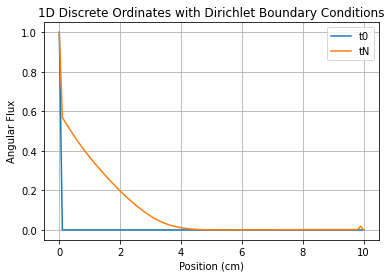

In [13]:
f_res_tn = w_q @ f_tN / 2.
f_res_t0 = w_q @ f_init / 2.
# Plot the angular flux for one angle (e.g., the first angle)
plt.plot(np.linspace(0, L, n_x), f_res_t0)
plt.plot(np.linspace(0, L, n_x), f_res_tn)
plt.xlabel('Position (cm)')
plt.ylabel('Angular Flux')
plt.title('1D Discrete Ordinates with Dirichlet Boundary Conditions')
plt.legend(['t0', 'tN'])
plt.grid(True)

In [20]:
f_tN = run_simulation(f_init, n_x, n_q, n_t, dt, dx, sigma_s, sigma_t, source, omega, models[5], grid, w_q, True)

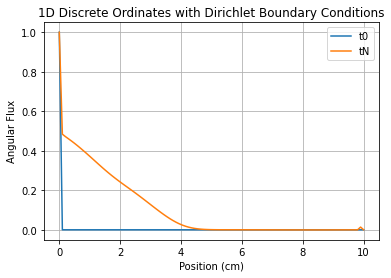

In [26]:
f_res_tn = w_q @ f_tN / 2.
f_res_t0 = w_q @ f_init / 2.
# Plot the angular flux for one angle (e.g., the first angle)
plt.plot(np.linspace(0, L, n_x), f_res_t0)
plt.plot(np.linspace(0, L, n_x), f_res_tn)
plt.xlabel('Position (cm)')
plt.ylabel('Angular Flux')
plt.title('1D Discrete Ordinates with Dirichlet Boundary Conditions')
plt.legend(['t0', 'tN'])
plt.grid(True)
#plt.savefig("hard_special.png")